In [ ]:
# train_cnn.ipynb

In [ ]:
# Imports

# Needed for grabbing local python files
import sys
import os

# ML library for creating models and training
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

# Used to iterate over a dataset
from torch.utils.data import random_split, DataLoader

# Show data
import matplotlib.pyplot as plt

In [ ]:
# Grab local imports
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(os.path.join(project_root, "src"))

from data.load_data import simple_train_dl, simple_val_dl
from models.cnn import CNN
from utils.progress import progress

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

In [ ]:
# Initialize model
cnn_model = CNN().to(device)

In [ ]:
def train_and_evaluate(model, train_dataloader, test_dataloader, epochs=1, lr=0.001):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_loss_history = []
    test_loss_history = []

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0

        for images, labels, _ in progress(train_dataloader, total_steps=len(train_dataloader)):
            images, labels = images.to(device), labels.to(device).float()
            #print('shp', images.shape)
            optimizer.zero_grad()
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_dataloader)
        train_loss_history.append(avg_train_loss)
        total_test_loss = 0

        with torch.no_grad():
            for images, labels, _ in test_dataloader:
                #print(images.squeeze().shape)
                images, labels = images.to(device), labels.to(device).float()
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

        avg_test_loss = total_test_loss / len(test_dataloader)
        test_loss_history.append(avg_test_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

    # Plot Learning Curve
    plt.plot(range(1, epochs+1), train_loss_history, label="Train Loss", marker='o')
    plt.plot(range(1, epochs+1), test_loss_history, label="Test Loss", marker='o')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

Progress: 100.00% completed | ETA: 00m 00s
Epoch 1/5, Train Loss: 1.2699, Test Loss: 1.1970
Progress: 100.00% completed | ETA: 00m 00s
Epoch 2/5, Train Loss: 1.1602, Test Loss: 1.3282
Progress: 100.00% completed | ETA: 00m 00s
Epoch 3/5, Train Loss: 1.1054, Test Loss: 1.1743
Progress: 100.00% completed | ETA: 00m 00s
Epoch 4/5, Train Loss: 1.0918, Test Loss: 1.1687
Progress: 100.00% completed | ETA: 00m 00s
Epoch 5/5, Train Loss: 1.0693, Test Loss: 1.1336


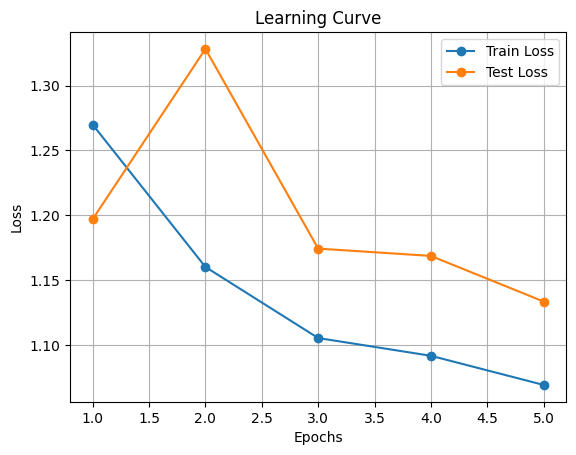

In [ ]:
train_and_evaluate(cnn_model, simple_train_dl, simple_val_dl, epochs=2)

Accuracy: 25.26%
RMSE: 1.5483


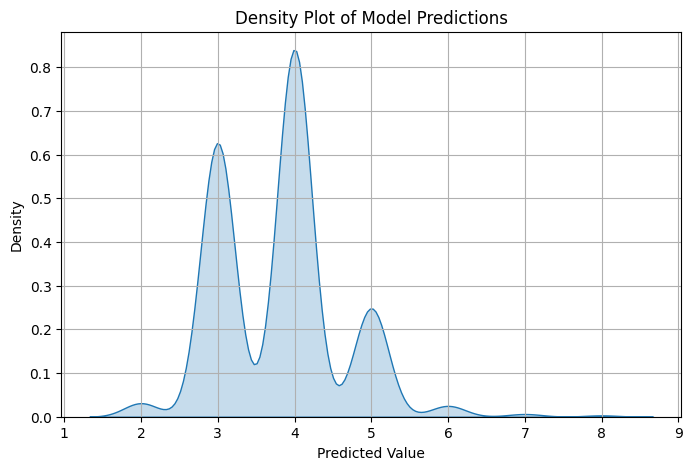

In [8]:
import seaborn as sns

def evaluate_model(model, test_dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    total_samples = 0
    correct_predictions = 0
    total_absolute_error = 0.0

    rmse_arr = []
    all_outputs = []

    with torch.no_grad():
        for images, labels, _ in test_dataloader:
            images, labels = images.to(device), labels.to(device).float()
            outputs = model(images)  # Remove squeeze here, keep dimensions intact

            # Flatten if needed, but safely
            outputs = outputs.view(-1)
            labels = labels.view(-1)

            predictions = torch.round(outputs)
            correct_predictions += (predictions == labels).sum().item()

            total_samples += labels.size(0)

            # Store RMSE per sample
            rmse_arr.extend((labels - outputs).abs().cpu().numpy())
            all_outputs.append(float(predictions.cpu()))

    accuracy = correct_predictions / total_samples * 100
    rmse = sum(rmse_arr) / len(rmse_arr)

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"RMSE: {rmse:.4f}")

    # Density plot of predictions
    plt.figure(figsize=(8, 5))
    #print(all_outputs)
    sns.kdeplot(all_outputs, fill=True)
    plt.title("Density Plot of Model Predictions")
    plt.xlabel("Predicted Value")
    plt.ylabel("Density")
    plt.grid(True)
    plt.show()


evaluate_model(cnn_model, simple_val_dl)